## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Pipeline

### 1.Compute the camera calibration matrix and distortion coefficients
* Read in calibration images
* Generate object points
* Find the image points
* Get camera calibration matrix and distortion coefficients

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Caculate the calibration matrix and distortion coefficients
# And apply the matrix an coefficients to images[1]
img = cv2.imread(images[1])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]), None, None)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(img)
ax1.set_title('Original image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistort image', fontsize=30)

# Save the matx and coefficients to pickle file
undist_pickle = {}
undist_pickle['mtx'] = mtx
undist_pickle['dist'] = dist
pickle.dump(undist_pickle, open('../camera_cal/mtx_dist_pickle.p', 'wb'))

### 2. Apply the calibration matrix and distortion coefficients
* Read in test images
* Apply the matrix and coefficients generated in Step 1

Text(0.5,1,'Undistort image')

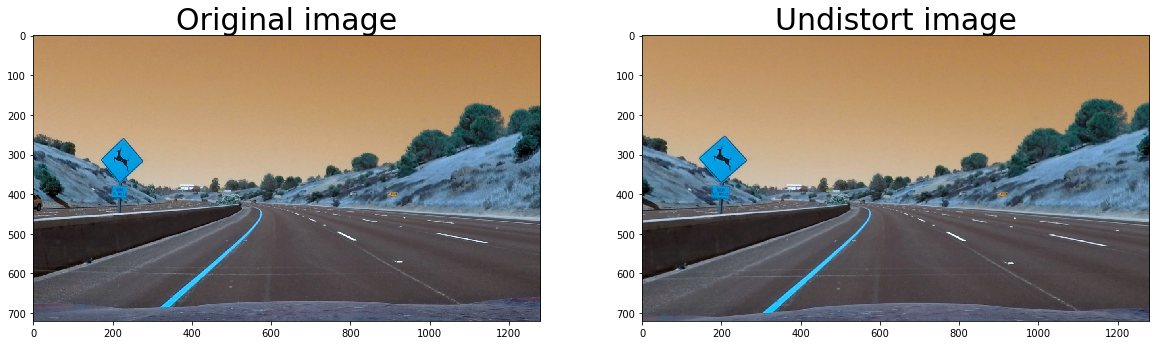

In [2]:
# Read the calibartion matrix and distortion coefficients from the save .p file
with open('../camera_cal/mtx_dist_pickle.p', 'rb') as f:
    camera_calib = pickle.load(f)

mtx = camera_calib['mtx']
dist = camera_calib['dist']

# Make a list of test images
test_images = glob.glob('../test_images/test*.jpg')

# Handle each test image
for fname in test_images:
    img = cv2.imread(fname)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    
# Take the last image as the example
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(img)
ax1.set_title('Original image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistort image', fontsize=30)

### 3. Create a thresholded binary image
* Threshold x gradient(for grayscaled image)
* Threshold color S channel
* Combine the two binary threshold into one

Text(0.5,1,'Binary threshold image')

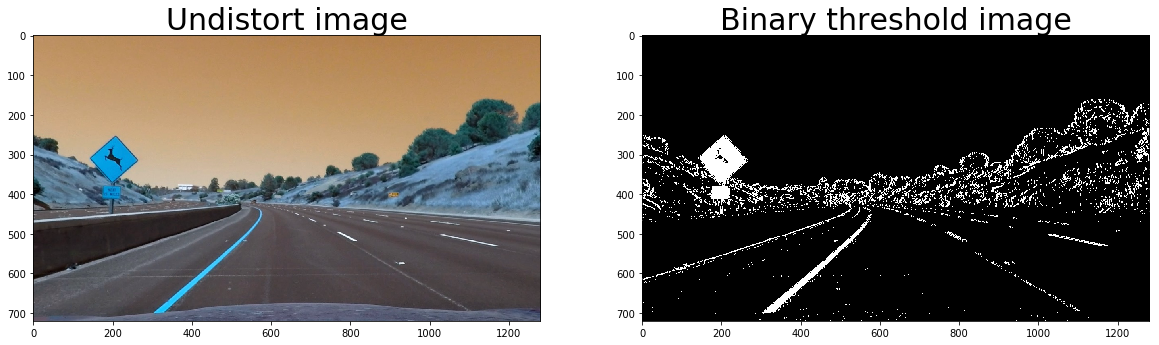

In [3]:
def apply_threshold(image, sobel_kernel=3, xgrad_thresh=(20, 100), s_thresh=(170, 255)):
    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    
    # Caculate the direction of the gradient
    xscaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Treshold gradient
    sx_binary = np.zeros_like(xscaled_sobel)
    sx_binary[(xscaled_sobel >= xgrad_thresh[0]) & (xscaled_sobel <= xgrad_thresh[1])] = 1
    
    # Treshold color channel
    hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel to view their individual contribution in green and blue respectively
    color_binary = np.dstack((np.zeros_like(sx_binary), sx_binary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
    
    return combined_binary

img_threshold_binary = apply_threshold(undist_img)
# Take the last image as the example
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(undist_img)
ax1.set_title('Undistort image', fontsize=30)
ax2.imshow(img_threshold_binary, cmap='gray')
ax2.set_title('Binary threshold image', fontsize=30)

### 3. Prespective transform to bird-eye view
* Transform the image from the car camera's perspective to a bird-eye-view perspective
* Hard-code the source and destination polygon coordinates(as the following table shows) and obtain the matrix M that maps them on each other
* Masking the image only for the region of interest(lane area)
* Warp the image to the new bird-eye-view perspective

|Source     |Destination  |
|:---------:|:-----------:|
| 585, 460  |320, 0       |
| 203, 720  |320, 720     |
| 1127, 720 |960, 720     |
| 695, 460  |960, 0       |

Text(0.5,1,'Perspective transform image')

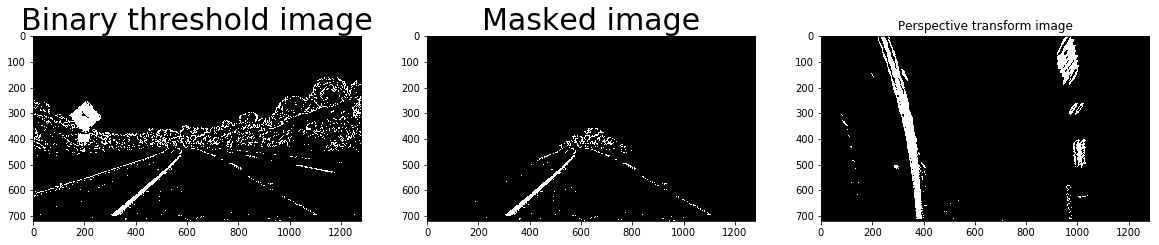

In [4]:
def calculate_vertices(image, height_percentage = 0.5, 
                       top_width_percentage = 0.04, 
                       bottom_width_percentage = 0.90):
    """
    Calculate vertices for a polygon
    """
    
    imshape = image.shape
    top_y = int(imshape[0] * (1 - height_percentage))
    top_left_x = int(imshape[1] * (1 - top_width_percentage)/2)
    top_right_x = int(imshape[1] - imshape[1] * (1 - top_width_percentage)/2)
    bottom_y = int(imshape[0])
    bottom_left_x = int(imshape[1] * (1 - bottom_width_percentage)/2)
    bottom_right_x = int(imshape[1] - imshape[1] * (1 - bottom_width_percentage)/2)    
    vertices = np.array([[(bottom_left_x, bottom_y),
                          (top_left_x, top_y), 
                          (top_right_x, top_y), 
                          (bottom_right_x, bottom_y)]], 
                        dtype=np.int32)
    return vertices

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def apply_perspective_transform(image):
    # hard-code src and dst coordinates for caculating the transform matrix
    src = np.float32(
        [[585, 460],
         [203, 720],
         [1127, 720],
         [695, 460]]
    )
    dst = np.float32(
        [[320, 0],
         [320, 720],
         [960, 720],
         [960, 0]]
    )
    
    # Get perspective transform matrix and also the reverse one
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Apply perspective transform
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

# Masking job
vertices = calculate_vertices(img_threshold_binary)
img_masked_edges = region_of_interest(img_threshold_binary, vertices)
warped_img, perspective_M, perspective_Minv = apply_perspective_transform(img_masked_edges)
# Take the last image as the example
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(img_threshold_binary, cmap='gray')
ax1.set_title('Binary threshold image', fontsize=30)
ax2.imshow(img_masked_edges, cmap='gray')
ax2.set_title('Masked image', fontsize=30)
ax3.imshow(warped_img, cmap='gray')
ax3.set_title('Perspective transform image')

### 4. Identify lane-line pixels and fit positions with a polynomial
* Divide the image into 'nwindows' windows(steps)
* For each step, find the boundaries of current window based on the starting point and 'margin' parameter
* For each step, find all the activated pixels
* Fit a polynomial to all the relevant pixels in the sliding windows
* Set the area to search for activated pixels based on 'margin' parameter, using function search_around_poly()

Text(0.5,1,'Lane fit image')

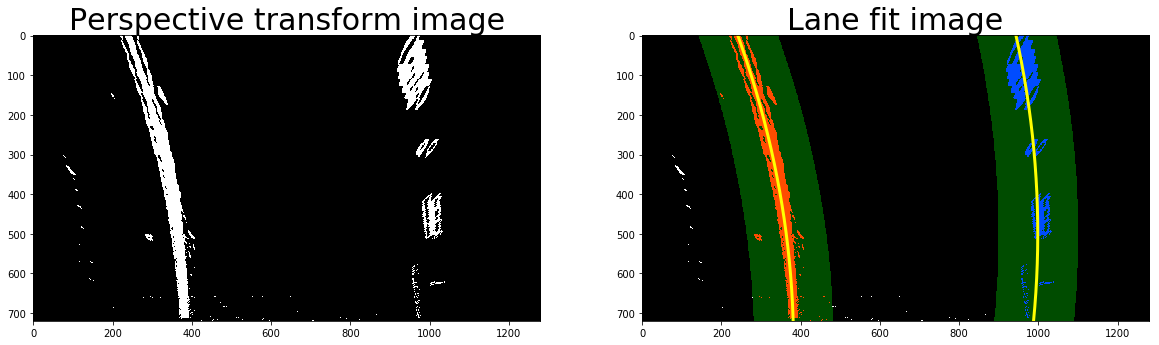

In [5]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return left_fitx, right_fitx, ploty, result

left_fitx, right_fitx, ploty, fit_polynomial_warped_img = search_around_poly(warped_img)
# Take the last image as the example
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(warped_img, cmap='gray')
ax1.set_title('Perspective transform image', fontsize=30)
ax2.imshow(fit_polynomial_warped_img)
ax2.plot(left_fitx, ploty, color='yellow', linewidth=3)
ax2.plot(right_fitx, ploty, color='yellow', linewidth=3)
ax2.set_title('Lane fit image', fontsize=30)

### 5. Calculate the radius of curvature of the lane and position of the vehicle with respect to the center
* Using the poly_fit coefficients to calculate the left_curve and right_curve curvature and offset for the vehicle position in the Image
* Convert the pixel scale to meters for curature and offset(vehicle position to the center)

In [53]:
def evaluate_poly(y, poly_coeffs):
    return poly_coeffs[0] * y ** 2 + poly_coeffs[1] * y + poly_coeffs[2]

def center(y, left_poly_fit, right_poly_fit):
    return (1.5 * evaluate_poly(y, left_poly_fit) - evaluate_poly(y, right_poly_fit)) / 2

def calc_radius_curvature(warped_transformed_img):
    left_fitx, right_fitx, ploty, fit_polynomial_warped_img = search_around_poly(warped_transformed_img)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit = np.polyfit(ploty, left_fitx, 2)
    right_fit = np.polyfit(ploty, right_fitx, 2)
    center_fit = (left_fitx + right_fitx) / 2
    offset = (warped_transformed_img.shape[1] / 2 - center_fit[719]) * 3.7 /700
    
    left_fit_meter = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_meter = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    y_eval = np.max(ploty)
    
    left_curve_rad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    right_curve_rad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])
    left_curve_meter = ((1 + (2 * left_fit_meter[0] * y_eval * ym_per_pix + left_fit_meter[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_meter[0])
    right_curve_meter = ((1 + (2 * right_fit_meter[0] * y_eval * ym_per_pix + right_fit_meter[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_meter[0])
    
    return left_curve_rad, right_curve_rad, offset, left_curve_meter, right_curve_meter


left_curve_rad, right_curve_rad, offset, left_curve_meter, right_curve_meter = calc_radius_curvature(warped_img)

str_side = 'right'
if offset < 0:
    str_side = 'left'
    
print('Vehicle is {0:f} m {1:s} of center'.format(abs(offset), str_side))
print('\nLeft lane curve radius: ', left_curve_rad)
print('Right lane curve radius: ', right_curve_rad)
print('\nLeft lane curve radius in real world: {0:f} m'.format(left_curve_meter))
print('Right lane curve radius in real world: {0:f} m'.format(right_curve_meter))

Vehicle is 0.236450 m left of center

Left lane curve radius:  2192.1294185762163
Right lane curve radius:  2306.8113055038393

Left lane curve radius in real world: 719.075795 m
Right lane curve radius in real world: 747.408772 m


### 6. Plot result back down onto the road such that the lane area is identified clearly
* Warp the lane lines back on undistorted image
* Combine lane lines with undistorted image

Text(0.5,1,'Undistort image with lane lines area')

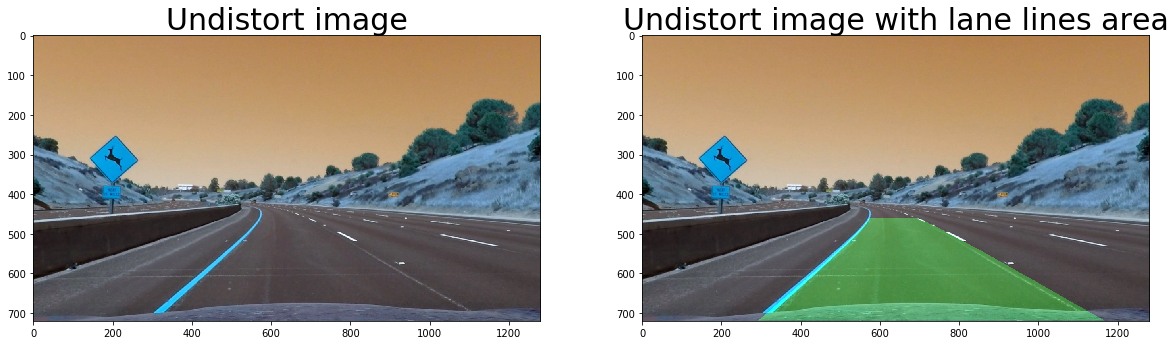

In [54]:
def add_lane_lines_to_image(undist_image, warped_image, Minv):
    left_fitx, right_fitx, ploty, fit_polynomial_warped_img = search_around_poly(warped_image)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_image.shape[1], undist_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)

    return result

img_add_lane_lines = add_lane_lines_to_image(undist_img, warped_img, perspective_Minv)
# Take the last image as the example
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(undist_img, cmap='gray')
ax1.set_title('Undistort image', fontsize=30)
ax2.imshow(img_add_lane_lines)
ax2.set_title('Undistort image with lane lines area', fontsize=30)

### 7. Output visual display of numerical estimation of lane curvature and vehicle position

Text(0.5,1,'Undistort image with lane lines area & figure')

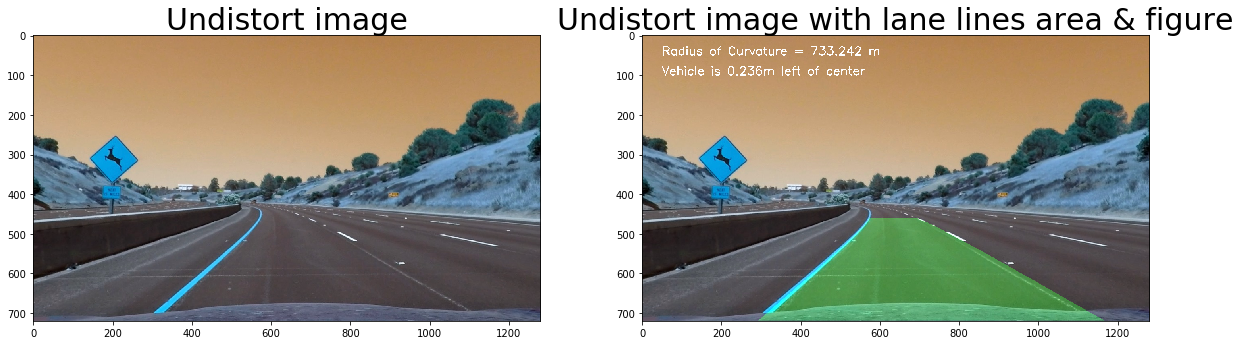

In [56]:
def add_figure_to_image(undist_image, curvature, position):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(undist_image, 'Radius of Curvature = %.3f m' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
    str_side = 'right'
    if position < 0:
        str_side = 'left'
        
    cv2.putText(undist_image, 'Vehicle is %.3fm %s of center' % (np.abs(position), str_side), (50, 100), font, 1,
                (255, 255, 255), 2)
    
    return undist_image

img_add_figure = add_figure_to_image(img_add_lane_lines, (left_curve_meter + right_curve_meter)/2.0, offset)
# Take the last image as the example
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(undist_img, cmap='gray')
ax1.set_title('Undistort image', fontsize=30)
ax2.imshow(img_add_lane_lines)
ax2.set_title('Undistort image with lane lines area & figure', fontsize=30)